#### Handle the imports

In [1]:
from nipype import Node, Workflow
from nipype.interfaces.utility import IdentityInterface, Function
from nipype.interfaces import freesurfer, fsl, mrtrix
from nipype.interfaces.dcm2nii import Dcm2nii
from nipype.interfaces.io import DataFinder
from nipype import utils as nputils

In [2]:
from multiprocessing import cpu_count
import numpy as np
import logging, os, shutil

#### Define a function for the preprocessing workflow

In [ ]:
# def preproc_sub(subject_folder, subject_id):

#### Start the logging

In [3]:
logger = logging.getLogger('interface')
logger.setLevel(logging.DEBUG)
# create console handler and set level to debug
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
# create formatter
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
# add formatter to ch
ch.setFormatter(formatter)
# add ch to logger
logger.addHandler(ch)

#### Define the later function variables in hard-code for debuging

In [4]:
subject_folder = '/Users/srothmei/Desktop/charite/toronto/'
subject_id = 'FR_20120903'

### Define Inputnode and Outputnode

In [5]:
inputNode = Node(IdentityInterface(fields=['subject_id', 'subject_folder']), mandatory_inputs=True, name='input')
inputNode.inputs.subject_id = subject_id
inputNode.inputs.subject_folder = subject_folder

# TODO: Define Output node

### Utility Nodes

In [6]:
def extractB0(dwMriFile):
    # This function is used to extract the b0 image out of the 4D series of diffusion images by splitting the
    # series, copying the first image and merging the images together into a single file afterwards
    pth, fname, ext = nputils.filemanip.split_filename(dwMriFile)
    currPth = os.path.realpath('.')

    # Change dir because FSL split takes no input for storing things somewhere else....
    os.chdir(pth)    

    splitter = fsl.utils.Split(dimension = 't', out_base_name = 'tmp_', in_file = dwMriFile)
    res = splitter.run()
    b0 = res.outputs.out_files[0]

    # Copy the b0 image and rename it accordingly
    shutil.copy(b0, 'no_diffusion.nii.gz')
    b0 = os.path.abspath('no_diffusion.nii.gz')

    # Delete the sliced files...
    for f in res.outputs.out_files:
        os.remove(f)

    # Change back into previous directory
    os.chdir(currPth)
    
    return b0

## Set parameters and build variables

In [7]:
reconallFolderName = 'recon_all' # Define what the output folder of recon-all should be named

def pathBuilder(subject_folder, subject_id, ):
    subPath = subject_folder + '/' + subject_id # Build full path to subject folder
    
    #Path definitions
    dwiPreprocFolder = subPath + '/diff_processed'
    trackingFolder = subPath + '/tractography'
    
    # Make folders
    os.makedirs(dwiPreprocFolder)
    os.makedirs(trackingFolder)
    
    # RawData Structure
    rawdataFolder = subPath + '/RAWDATA' # Define the path to the folder holding the rawdata dicom-files
    T1RawFolder = rawdataFolder + '/MPRAGE/' # The T1 rawdata folder
    dwiRawFolder = rawdataFolder + '/DTI' # The dwMRI rawdata folder
    fmriRawFolder = rawdataFolder + '/BOLD-EPI/' # The fMRI rawdata folder
    
    return subPath, rawdataFolder, T1RawFolder, dwiRawFolder, fmriRawFolder, dwiPreprocFolder, trackingFolder

pathBuildingNode = Node(Function(input_names = ['subject_folder', 'subject_id'],
                                output_names = ['subPath', 'rawdataFolder', 'T1RawFolder',
                                                'dwiRawFolder', 'fmriRawFolder', 
                                                'dwiPreprocFolder', 'trackingFolder'],
                                function = pathBuilder),
                        name='pathBuilder')

In [8]:
logger.info('Start the preprocessing for subject ' + subject_id)

2015-11-03 16:31:49,282 - INFO - Start the preprocessing for subject FR_20120903
INFO:interface:Start the preprocessing for subject FR_20120903


### Structural Data (T1) preprocessing

In [9]:
logger.info('Start recon_all')

# Setup a datafinder to find the paths to the specific DICOM files
t1FinderNode = Node(DataFinder(), name = 't1Finder')
t1FinderNode.inputs.match_regex = '.*\.dcm'
#df = DataFinder(root_paths = T1RawFolder, match_regex = '.*\.dcm')
#firstFile = df.run().outputs.out_paths[0]

# Set recon-all parameters
reconallNode = Node(freesurfer.preprocess.ReconAll(), name = 'reconall')
#reconallNode.inputs.T1_files = firstFile
#reconallNode.inputs.subjects_dir = subPath
reconallNode.inputs.subject_id = reconallFolderName
reconallNode.inputs.directive = 'all'
reconallNode.inputs.openmp = cpu_count()

# Convert the T1 mgz image to nifti format for later usage
mriConverter = Node(freesurfer.preprocess.MRIConvert(), name = 'convertAparcAseg')
#convertT1.inputs.out_file = subPath + reconallFolderName + '/mri/aparc+aseg.nii.gz'
mriConverter.inputs.out_type = 'niigz'
mriConverter.inputs.out_orientation = 'RAS'

2015-11-03 16:31:50,872 - INFO - Start recon_all
INFO:interface:Start recon_all


### Diffusion Data (dwMRI) preprocessing

In [31]:
logger.info('Start dt_recon')

# First extract the diffusion vectors and the pulse intensity (bvec and bval)
# Use dcm2nii for this task
#dwiFinderNode = t1FinderNode.clone('dwiFinder')

dcm2niiNode = Node(Dcm2nii(), name = 'dcm2niiAndBvecs')
dcm2niiNode.inputs.gzip_output = True
dcm2niiNode.inputs.date_in_filename = False
dcm2niiNode.inputs.events_in_filename = False


# Extract the first image of the DTI series i.e. the b0 image
extrctB0Node = Node(Function(input_names = ['dwMriFile'], output_names = ['b0'],
                             function = extractB0), name = 'Extract_b0')


# Perform the registration between subject T1 space and dwMRI space
bbregNode = Node(freesurfer.preprocess.BBRegister(), name = 'BBRegister')
bbregNode.inputs.init = "fsl"
bbregNode.inputs.contrast_type = "t2"
bbregNode.inputs.epi_mask = True
bbregNode.inputs.out_fsl_file = True
bbregNode.inputs.args = "--tol1d 1e-3"
bbregNode.inputs.subject_id = reconallFolderName
bbregNode.inputs.out_reg_file = str(pathBuildingNode.outputs.dwiPreprocFolder) + '/register.dat'


2015-11-03 16:52:40,194 - INFO - Start dt_recon
INFO:interface:Start dt_recon


### Connect the Nodes

In [32]:
wf = Workflow(name = 'preprocSub')

# Input strings to pathbuilder
wf.connect([(inputNode, pathBuildingNode, [('subject_id', 'subject_id'),
                                          ('subject_folder', 'subject_folder')])])
# T1-Rawdata-path into dataFinder to find T1 DICOMs
wf.connect(pathBuildingNode, 'T1RawFolder', t1FinderNode, 'root_paths')
# T1 DICOM-paths into recon_all
wf.connect(t1FinderNode, 'out_paths', reconallNode, 'T1_files')
# aparc+aseg into mriConverter
wf.connect(reconallNode, 'aparc_aseg', mriConverter, 'in_file')

# dcm2nii
wf.connect([(pathBuildingNode, dcm2niiNode, [('dwiRawFolder', 'source_names'),
                                            ('dwiPreprocFolder', 'output_dir')])])
# B0 extraction
wf.connect(dcm2niiNode, 'converted_files', extrctB0Node, 'dwMriFile')

# Register b0 into T1 space
wf.connect([(extrctB0Node, bbregNode, [('b0', 'source_file')]),
           (pathBuildingNode, bbregNode, [('dwiPreprocFolder', 'out_reg_file'),
                                         ('subPath', 'subjects_dir')])])

In [33]:
fsl.Info.standard_image("MNI152_T1_1mm.nii.gz")
#bbregNode.inputs

'/usr/local/fsl/data/standard/MNI152_T1_1mm.nii.gz'

### Plot the workflow graph

DEBUG:interface:{'DISPLAY': ':1'}
INFO:workflow:Converting dotfile: /Users/srothmei/Documents/TVB-Pypeline/notebooks/workflow_graph.dot to png format


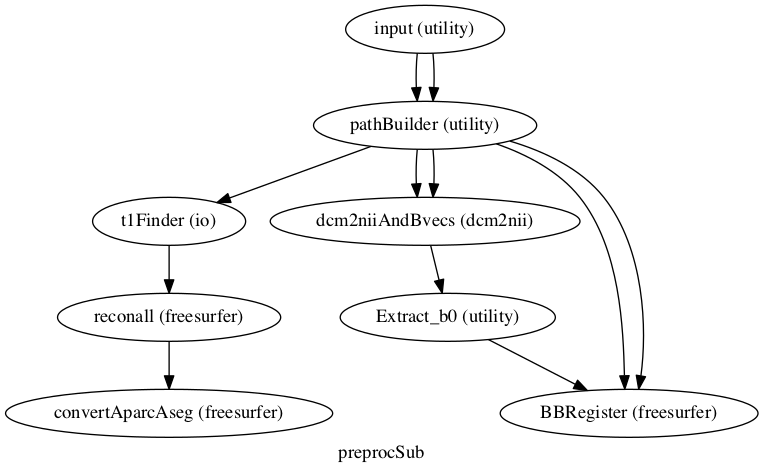

In [34]:
wf.write_graph("workflow_graph.dot")
from IPython.display import Image
Image(filename="workflow_graph.dot.png")
#from matplotlib import image as Image
#print(wf.write_graph.__doc__)